In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Process

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [2]:
class KArmsBandit:
    
    def __init__(self, arms, n_games = 1000, alpha = 0.1, OIV = False):
        
        self.arms = arms
        self.n_games = n_games
        self.alpha = alpha
        self.q_star = np.random.normal(0, 5, self.arms) #Actual mean reward
        
        #With Optimistic Initial Values
        if OIV:
            self.Q_greedy = np.zeros(self.arms) + 10 #Calculated expected rewards for greedy algo.
            self.Q_epsilon_greedy = np.zeros(self.arms) + 10 #Calculated expected rewards for epsilon greedy algo.
            self.Q_ucb = np.zeros(self.arms) + 10 #Calculated expected rewards for UCB algo.
            self.Q_gradient = np.zeros(self.arms) + 10 #Calculated expected rewards for Gradient algo.
        else:
            self.Q_greedy = np.zeros(self.arms) #Calculated expected rewards for greedy algo.
            self.Q_epsilon_greedy = np.zeros(self.arms) #Calculated expected rewards for epsilon greedy algo.
            self.Q_ucb = np.zeros(self.arms) #Calculated expected rewards for UCB algo.
            self.Q_gradient = np.zeros(self.arms) #Calculated expected rewards for Gradient algo.
        self.rewards = np.array([np.random.normal(self.q_star[_], 1, self.n_games) for _ in range(self.arms)])
        
    def __get_reward(self, arm, num):
        return self.rewards[arm][num]
    
    def play_game(self):
        
        t1 = Process(self._play_greedy())
        t2 = Process(self._play_epsilon_greedy())
        t3 = Process(self._play_ucb())
        t4 = Process(self._play_gradient_bandit())
        
        t4.start()
        t3.start()
        t2.start()
        t1.start()
        
        t1.join()
        t2.join()
        t3.join()
        t4.join()
        
        print("Game Completed!!")
        
    def _play_greedy(self):
        
        def select_arm():
            return np.argmax(self.Q_greedy, 0)
        
        actions = []
        rewards = []
        for _ in range(self.n_games):
            a = select_arm()
            actions.append(a+1)
            reward = self.__get_reward(a, _)
            rewards.append(reward)
            self.Q_greedy[a] = self.Q_greedy[a] + self.alpha * (reward - self.Q_greedy[a])
        self.greedy_results = (actions, np.array(rewards), np.sum(rewards)) 
    
    def _play_epsilon_greedy(self):
        
        def select_arm():
            if np.random.binomial(1,0.9,1):
                return np.argmax(self.Q_epsilon_greedy, 0)
            return np.random.choice(self.arms, 1)[0]
        
        actions = []
        rewards = []
        for _ in range(self.n_games):
            a = select_arm()
            actions.append(a+1)
            reward = self.__get_reward(a, _)
            rewards.append(reward)
            self.Q_epsilon_greedy[a] = self.Q_epsilon_greedy[a] + self.alpha * (reward - self.Q_epsilon_greedy[a])
        self.epsilon_greedy_results = (actions, np.array(rewards), np.sum(rewards))
    
    def _play_ucb(self):
        
        N = [1] * self.arms
        
        def select_arm(t):
            l_max  = -1
            arm = -1
            for i in range(self.arms):
                curr_val = self.Q_ucb[i] + 2 * np.sqrt(np.log(t+1)/N[i])
                if l_max < curr_val:
                    arm = i
                    l_max = curr_val
            N[arm] = N[arm]+1
            return arm
        
        actions = []
        rewards = []
        for _ in range(self.n_games):
            a = select_arm(_)
            actions.append(a+1)
            reward = self.__get_reward(a, _)
            rewards.append(reward)
            self.Q_ucb[a] = self.Q_ucb[a] + self.alpha * (reward - self.Q_ucb[a])
            
        self.ucb_results = (actions, np.array(rewards), np.sum(rewards))

    def _play_gradient_bandit(self):
        
        P = [1/self.arms] * self.arms
        
        def select_arm():
            return np.argmax(P, 0)
        
        actions = []
        rewards = []
        for _ in range(self.n_games):
            a = select_arm()
            actions.append(a+1)
            reward = self.__get_reward(a, _)
            rewards.append(reward)
            for i in range(self.arms):
                if i==a:
                    self.Q_gradient[a] = self.Q_gradient[a] + self.alpha * (reward - self.Q_gradient[a]) * (1-P[i])
                else:
                    self.Q_gradient[i] = self.Q_gradient[i] - self.alpha * (reward - self.Q_gradient[i]) * P[i]
            
            softmax = np.array(list(map(np.exp, self.Q_gradient)))
            P = softmax/np.sum(softmax)   

        self.gradient_results = (actions, np.array(rewards), np.sum(rewards))

In [3]:
def analyze(bandits, arms, games):
    # Analyzing the Q values
    plt.plot(range(arms), bandits.q_star, label = 'Actual Q Function', alpha = 0.5)
    plt.plot(range(arms), bandits.Q_greedy, label = 'Calculated Greedy Q values', alpha = 0.5)
    plt.plot(range(arms), bandits.Q_epsilon_greedy, label = 'Calculated epsilon Greedy Q values', alpha = 0.5)
    plt.plot(range(arms), bandits.Q_ucb, label = 'Calculated UCB Q values', alpha = 0.5)
    plt.plot(range(arms), bandits.Q_gradient, label = 'Calculated Gardient Q values', alpha = 0.5)
    plt.xlabel('Games')
    plt.ylabel('Values')
    plt.title('Q values')
    plt.legend(bbox_to_anchor=(2, 1.05), fancybox=True)
    plt.show()
    
    def rmse(a):
        return np.square(a[0]-a[1])
    print("Difference of Actual and calculated values for Greedy values:", 
          np.sqrt(np.mean(list(map(rmse, zip(bandits.q_star, bandits.Q_greedy))))), bandits.greedy_results[-1])
    print("Difference of Actual and calculated values for epsilon Greedy values:", 
          np.sqrt(np.mean(list(map(rmse, zip(bandits.q_star, bandits.Q_epsilon_greedy))))),bandits.epsilon_greedy_results[-1])
    print("Difference of Actual and calculated values for UCB values:", 
          np.sqrt(np.mean(list(map(rmse, zip(bandits.q_star, bandits.Q_ucb))))), bandits.ucb_results[-1])
    print("Difference of Actual and calculated values for Gradient values:", 
          np.sqrt(np.mean(list(map(rmse, zip(bandits.q_star, bandits.Q_gradient))))), bandits.gradient_results[-1])

    # Analyzing the Cummulative Rewards values
    plt.plot(range(games), np.cumsum(bandits.greedy_results[1]), label = 'Calculated Greedy Returns', alpha = 0.5)
    plt.plot(range(games), np.cumsum(bandits.epsilon_greedy_results[1]), label = 'Calculated epsilon Greedy Returns', alpha = 0.5)
    plt.plot(range(games), np.cumsum(bandits.ucb_results[1]), label = 'Calculated UCB Returns', alpha = 0.5)
    plt.plot(range(games), np.cumsum(bandits.gradient_results[1]), label = 'Calculated gradient Returns', alpha = 0.5)
    plt.xlabel('Games')
    plt.ylabel('Cummulative Returns')
    plt.title('Rewards')
    plt.legend(bbox_to_anchor=(1.1, 1.05), fancybox=True)
    plt.show()

    # Analyzing the Rewards values
    plt.plot(range(games), bandits.greedy_results[1], label = 'Calculated Greedy Returns', alpha = 0.5)
    plt.xlabel('Games')
    plt.ylabel('Returns')
    plt.title('Rewards')
    plt.legend(bbox_to_anchor=(1.1, 1.05), fancybox=True)
    plt.show()
    plt.plot(range(games), bandits.epsilon_greedy_results[1], label = 'Calculated epsilon Greedy Returns', alpha = 0.5)
    plt.xlabel('Games')
    plt.ylabel('Returns')
    plt.title('Rewards')
    plt.legend(bbox_to_anchor=(1.1, 1.05), fancybox=True)
    plt.show()
    plt.plot(range(games), bandits.ucb_results[1], label = 'Calculated UCB Returns', alpha = 0.5)
    plt.xlabel('Games')
    plt.ylabel('Returns')
    plt.title('Rewards')
    plt.legend(bbox_to_anchor=(1.1, 1.05), fancybox=True)
    plt.show()
    plt.plot(range(games), bandits.gradient_results[1], label = 'Calculated Gradient Returns', alpha = 0.5)
    plt.xlabel('Games')
    plt.ylabel('Returns')
    plt.title('Rewards')
    plt.legend(bbox_to_anchor=(1.1, 1.05), fancybox=True)
    plt.show()

    best_action=np.argmax(bandits.q_star)+1
    print("Best Action:", best_action)
    
    # Analyzing the Best Action Selection
    plt.plot(range(games), np.cumsum(np.where(np.array(bandits.greedy_results[0]) == best_action,1,0)), label = 'Best Greedy Action', alpha = 0.5)
    plt.plot(range(games), np.cumsum(np.where(np.array(bandits.epsilon_greedy_results[0]) == best_action,1,0)), label = 'Best epsilon Greedy Action', alpha = 0.5)
    plt.plot(range(games), np.cumsum(np.where(np.array(bandits.ucb_results[0]) == best_action,1,0)), label = 'Best UCB Action', alpha = 0.5)
    plt.plot(range(games), np.cumsum(np.where(np.array(bandits.gradient_results[0]) == best_action,1,0)), label = 'Best Gradient Action', alpha = 0.5)
    plt.xlabel('Games')
    plt.ylabel('Number of times Best Action selected')
    plt.title('Actions')
    plt.legend(bbox_to_anchor=(1.1, 1.05), fancybox=True)
    plt.show()
    
    # Analyzing the Best Action Selection
    plt.plot(range(games), np.where(np.array(bandits.greedy_results[0]) == best_action,1,0), label = 'Best Greedy Action', alpha = 0.5)
    plt.xlabel('Games')
    plt.ylabel('Number of times Best Action selected')
    plt.title('Actions')
    plt.legend(bbox_to_anchor=(1.1, 1.05), fancybox=True)
    plt.show()
    plt.plot(range(games), np.where(np.array(bandits.epsilon_greedy_results[0]) == best_action,1,0), label = 'Best epsilon Greedy Action', alpha = 0.5)
    plt.xlabel('Games')
    plt.ylabel('Number of times Best Action selected')
    plt.title('Actions')
    plt.legend(bbox_to_anchor=(1.1, 1.05), fancybox=True)
    plt.show()
    plt.plot(range(games), np.where(np.array(bandits.ucb_results[0]) == best_action,1,0), label = 'Best UCB Action', alpha = 0.5)
    plt.xlabel('Games')
    plt.ylabel('Number of times Best Action selected')
    plt.title('Actions')
    plt.legend(bbox_to_anchor=(1.1, 1.05), fancybox=True)
    plt.show()
    plt.plot(range(games), np.where(np.array(bandits.gradient_results[0]) == best_action,1,0), label = 'Best Gradient Action', alpha = 0.5)
    plt.xlabel('Games')
    plt.ylabel('Number of times Best Action selected')
    plt.title('Actions')
    plt.legend(bbox_to_anchor=(1.1, 1.05), fancybox=True)
    plt.show()

Game Completed!!


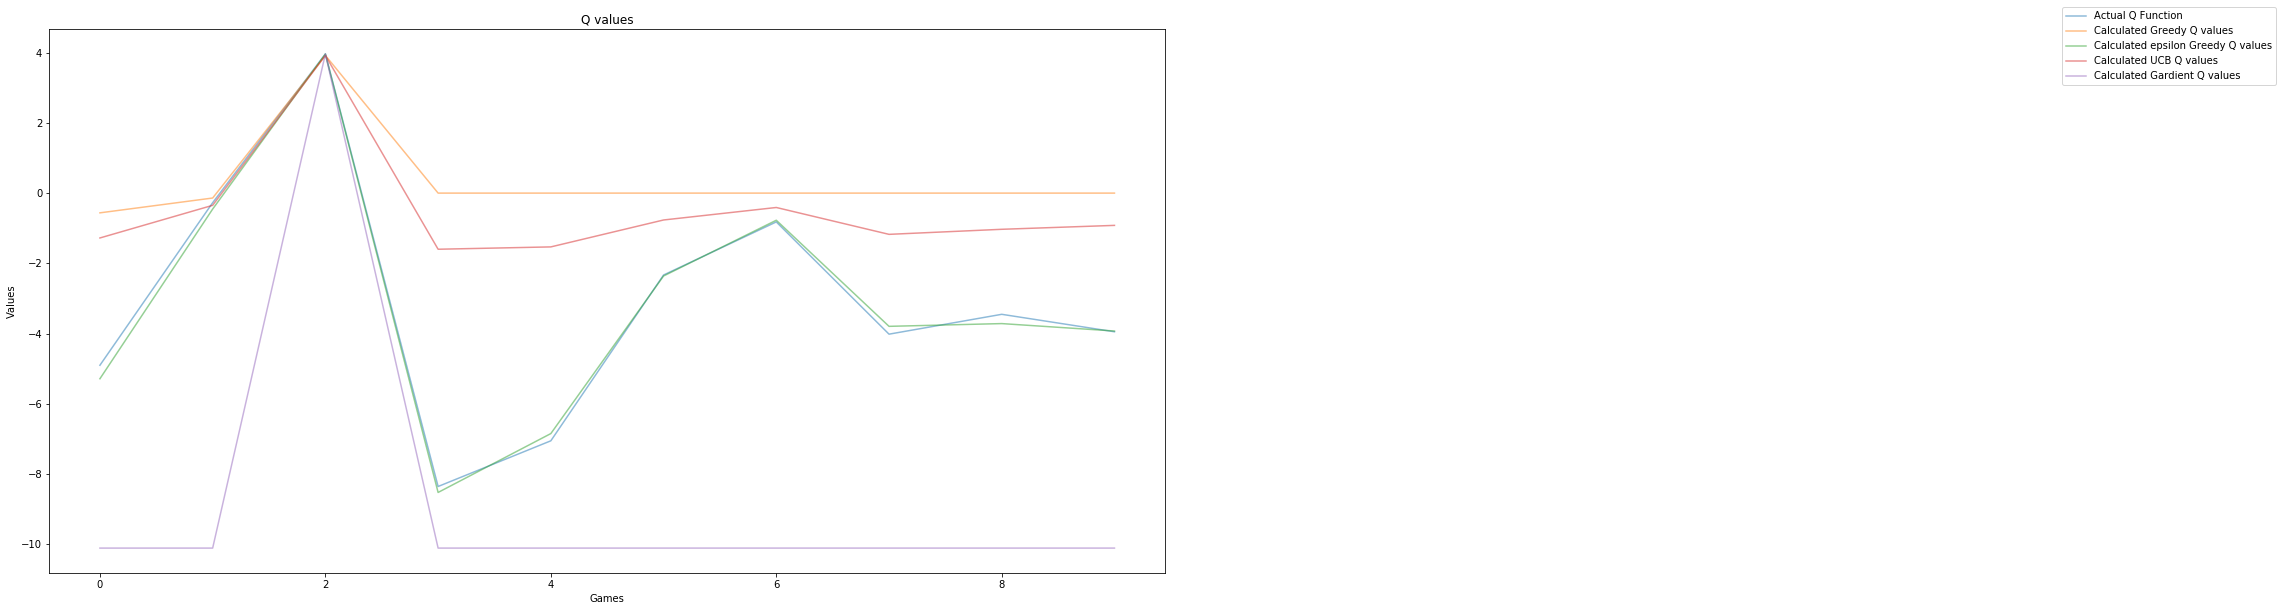

Difference of Actual and calculated values for Greedy values: 4.33918347075338 3964043.103016896
Difference of Actual and calculated values for epsilon Greedy values: 0.19364129517252637 3255774.679599174
Difference of Actual and calculated values for UCB values: 3.3925709474510883 3963826.0003986396
Difference of Actual and calculated values for Gradient values: 6.345267918875316 3964043.103016896


/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


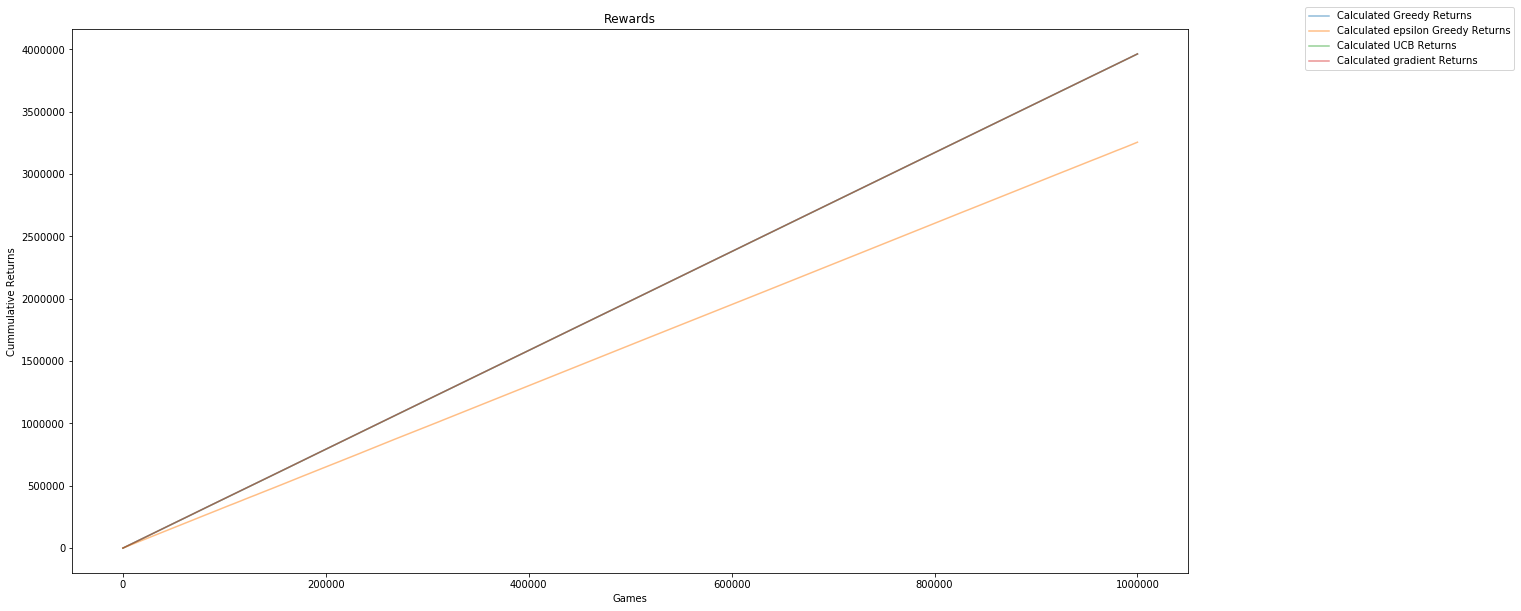

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


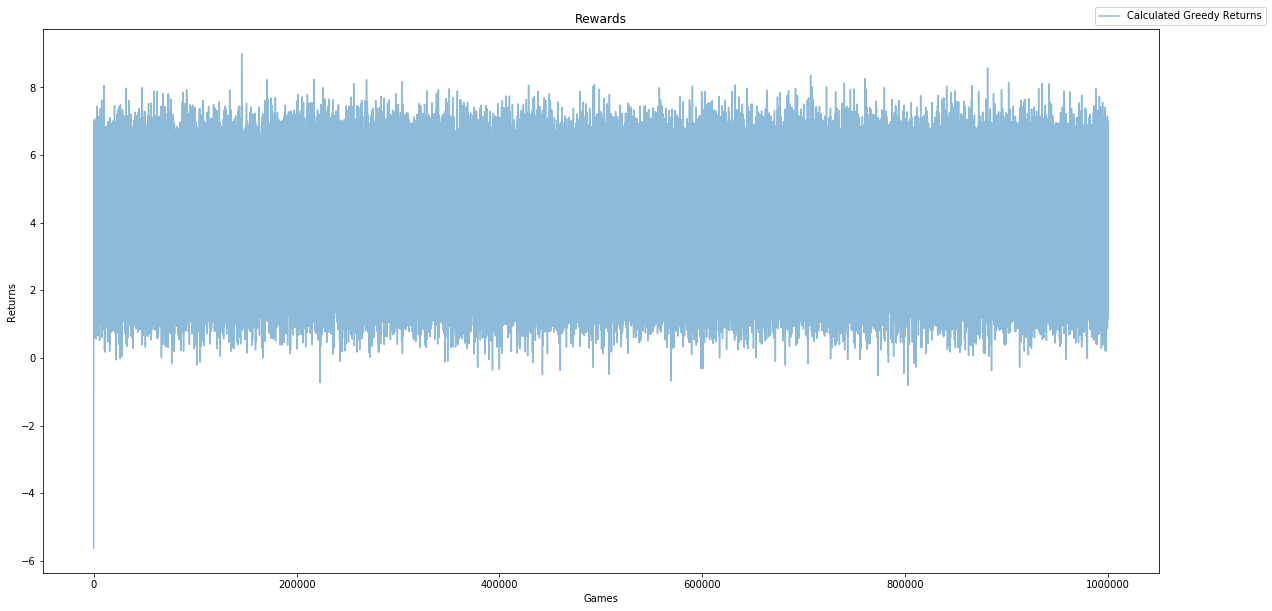

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


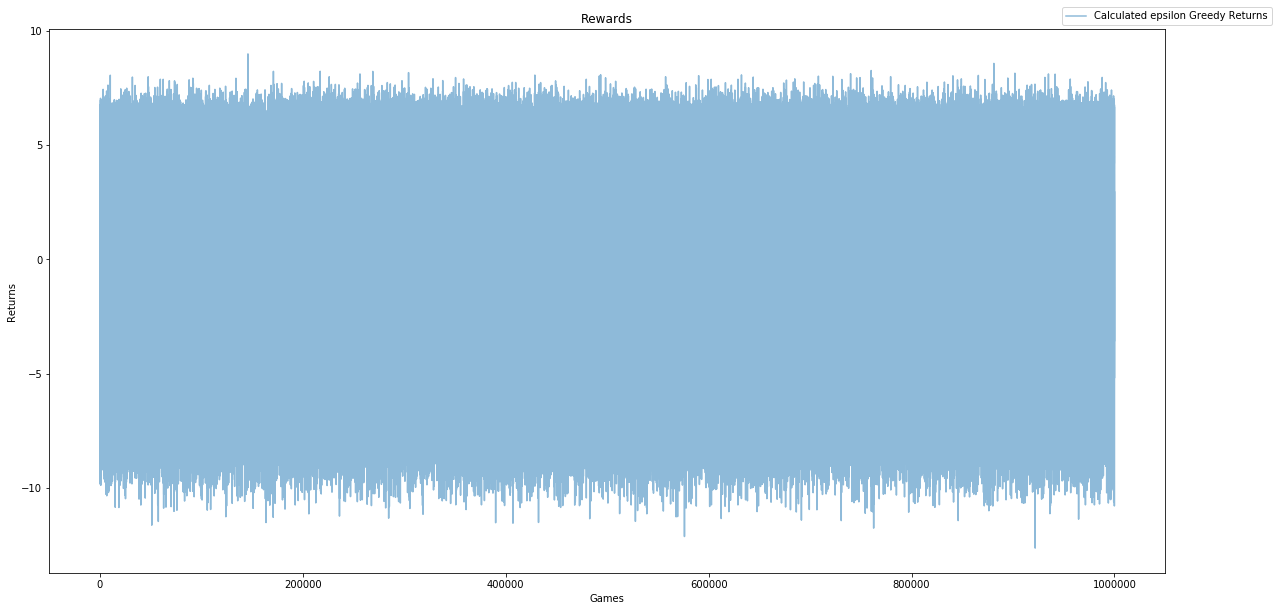

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


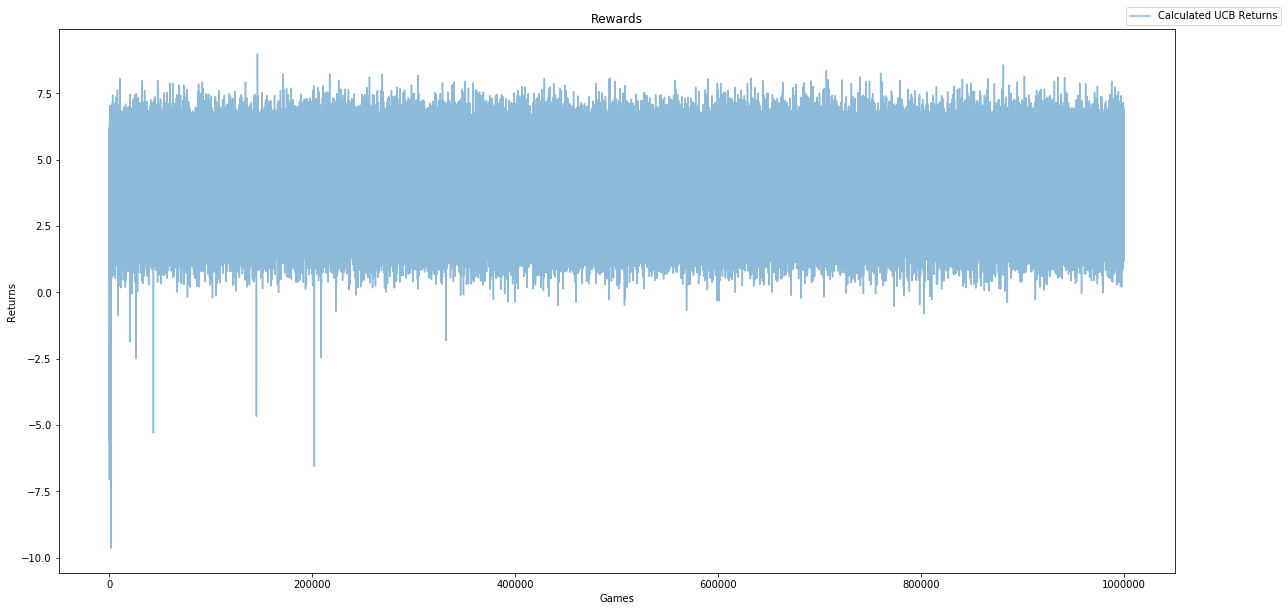

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


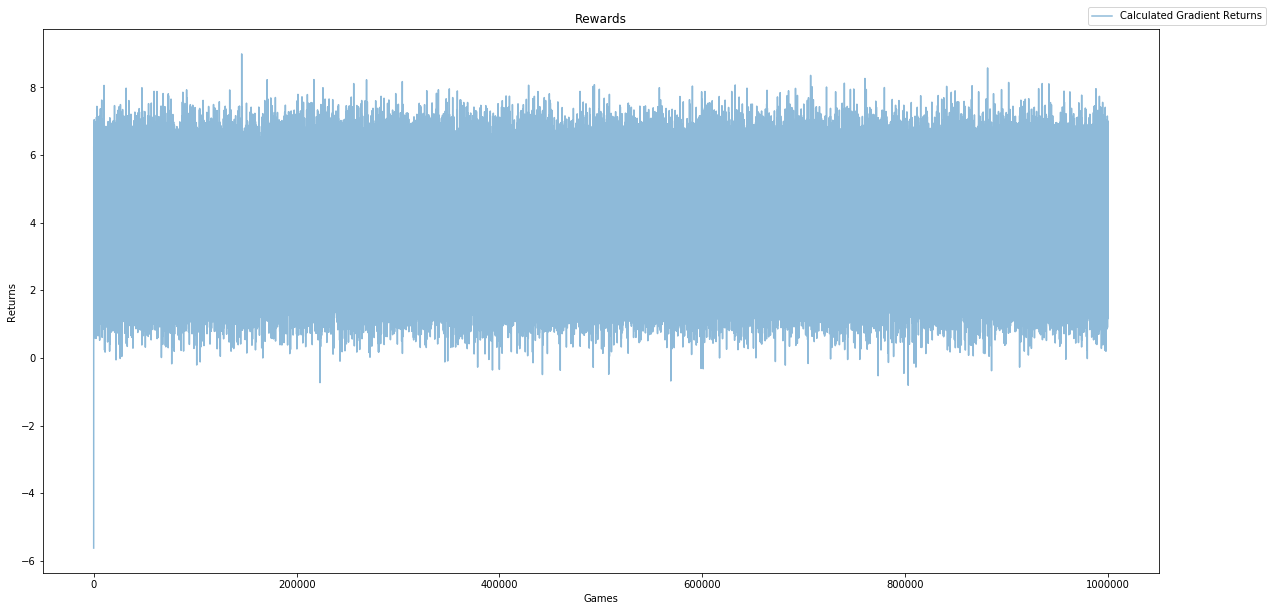

Best Action: 3


/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


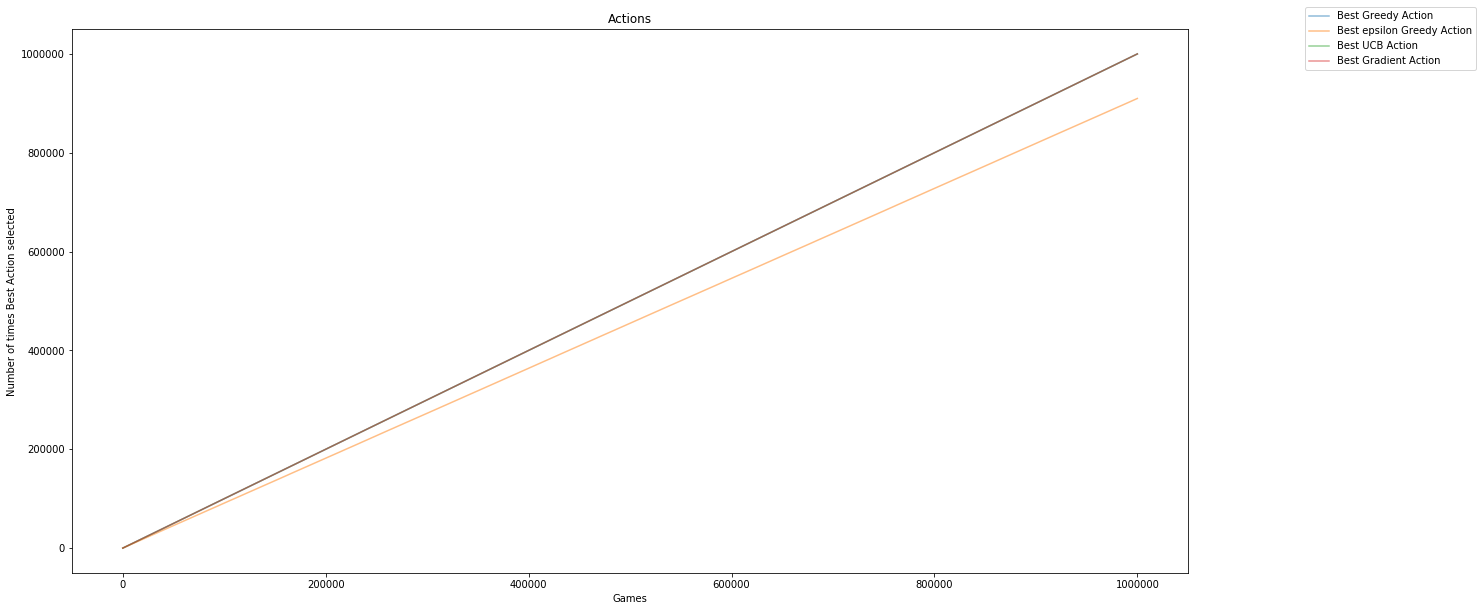

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


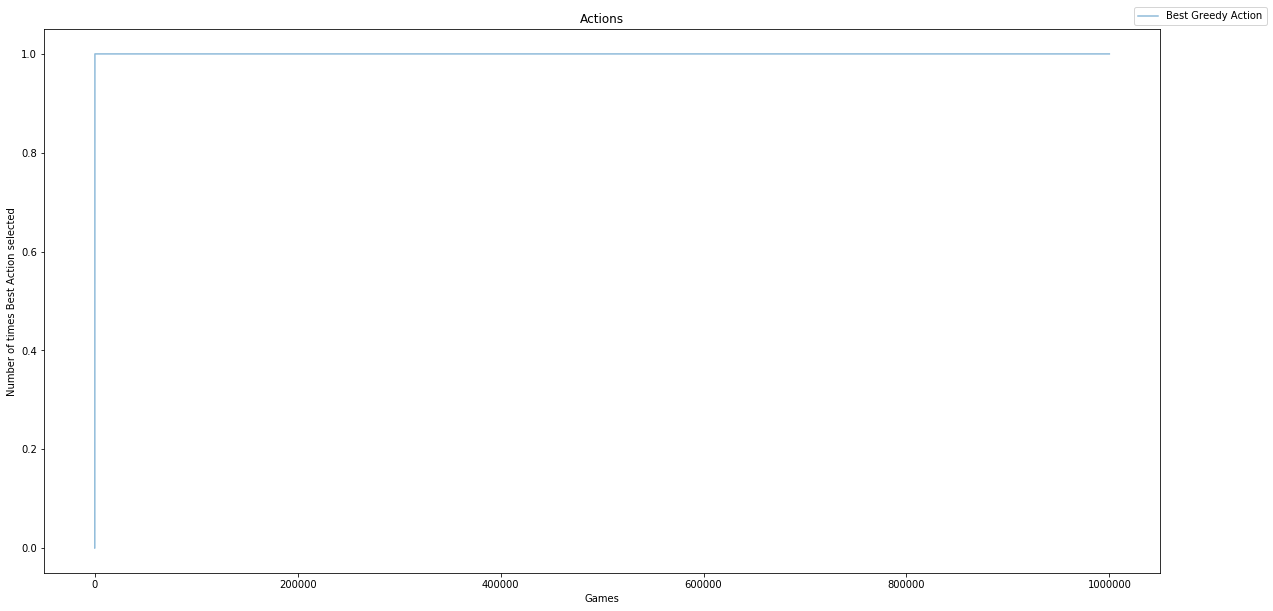

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


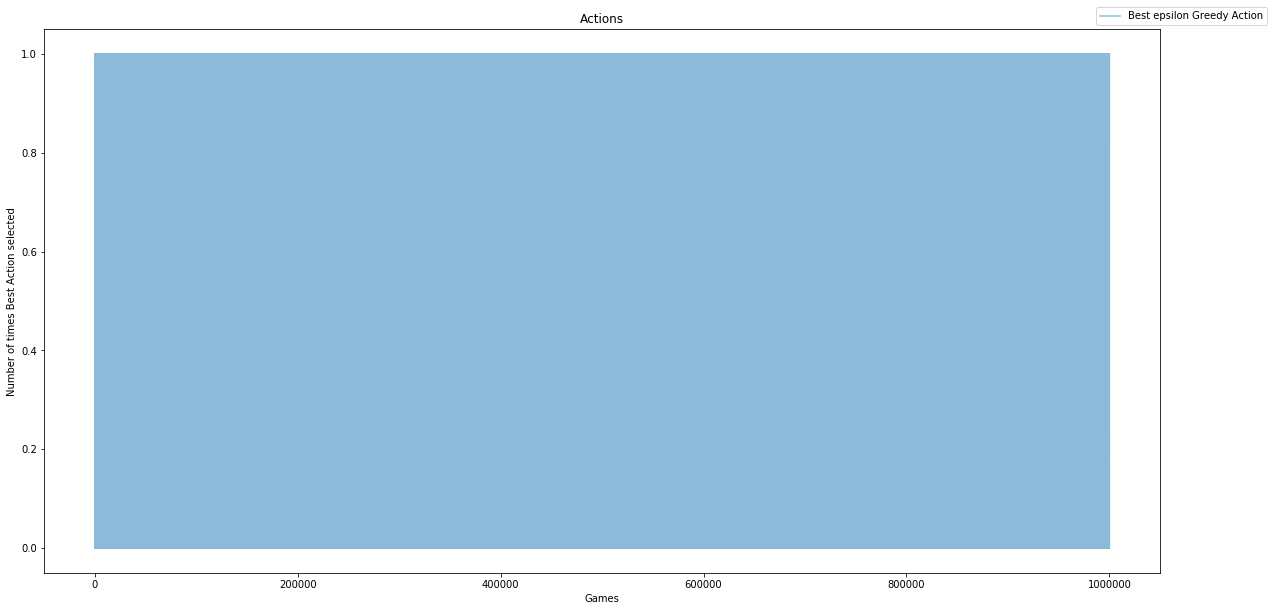

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


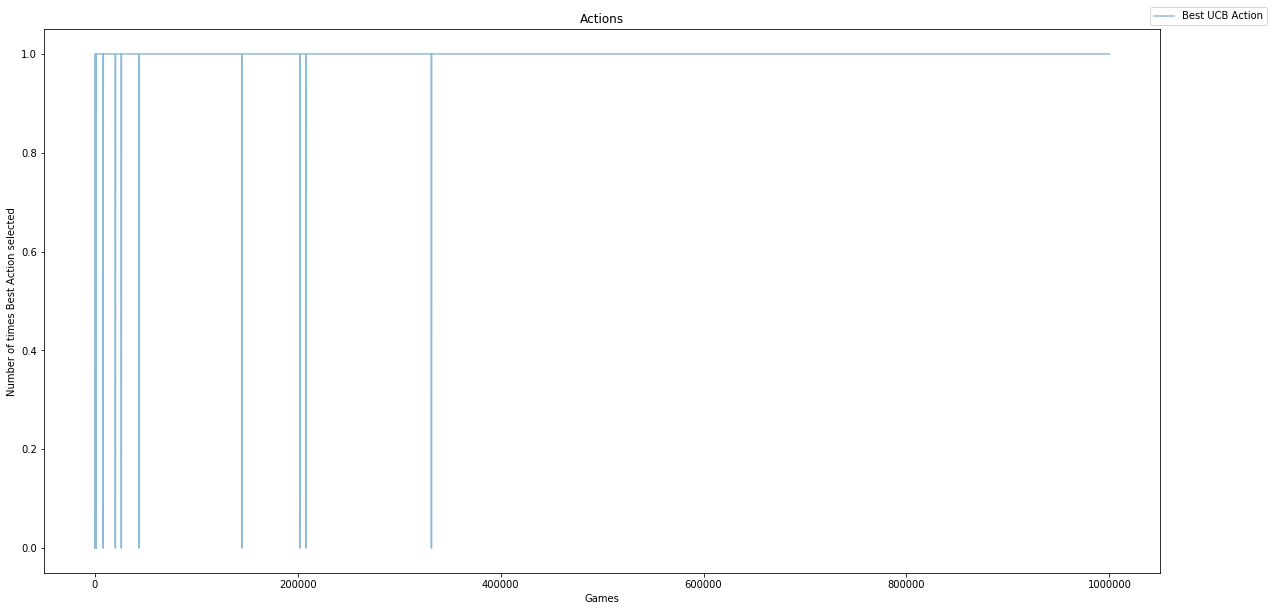

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


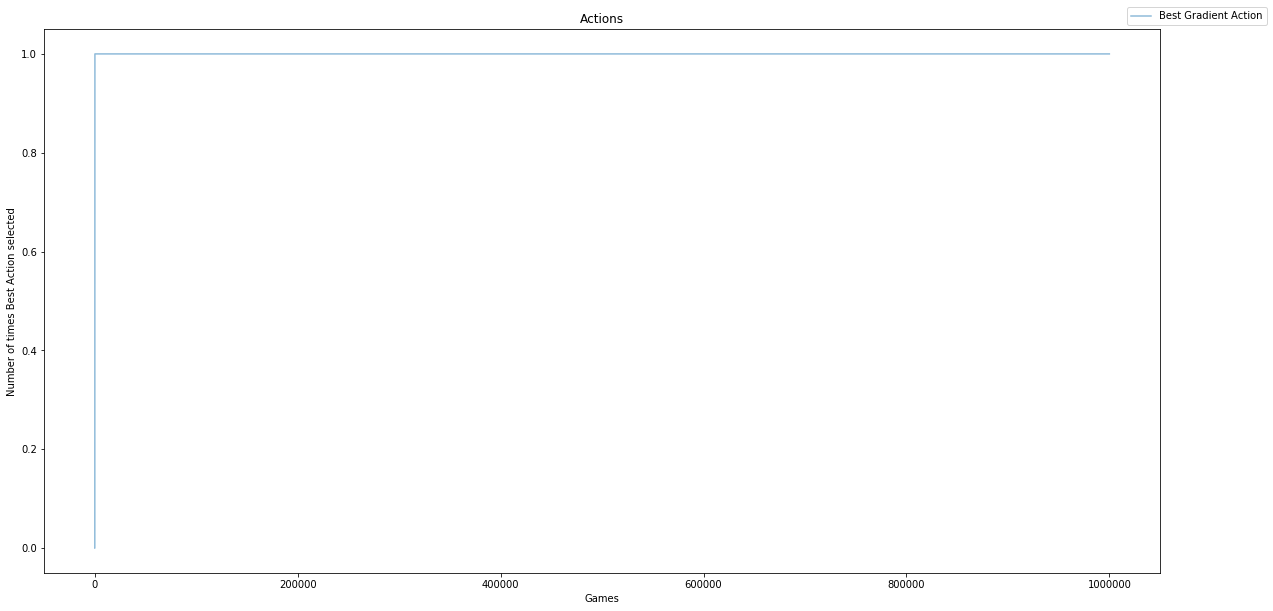

In [4]:
# Without the Optimistic initial values
arms = 10
games = 1000000
bandits = KArmsBandit(arms, n_games=1000000)
bandits.play_game()
analyze(bandits, arms, games)

Game Completed!!


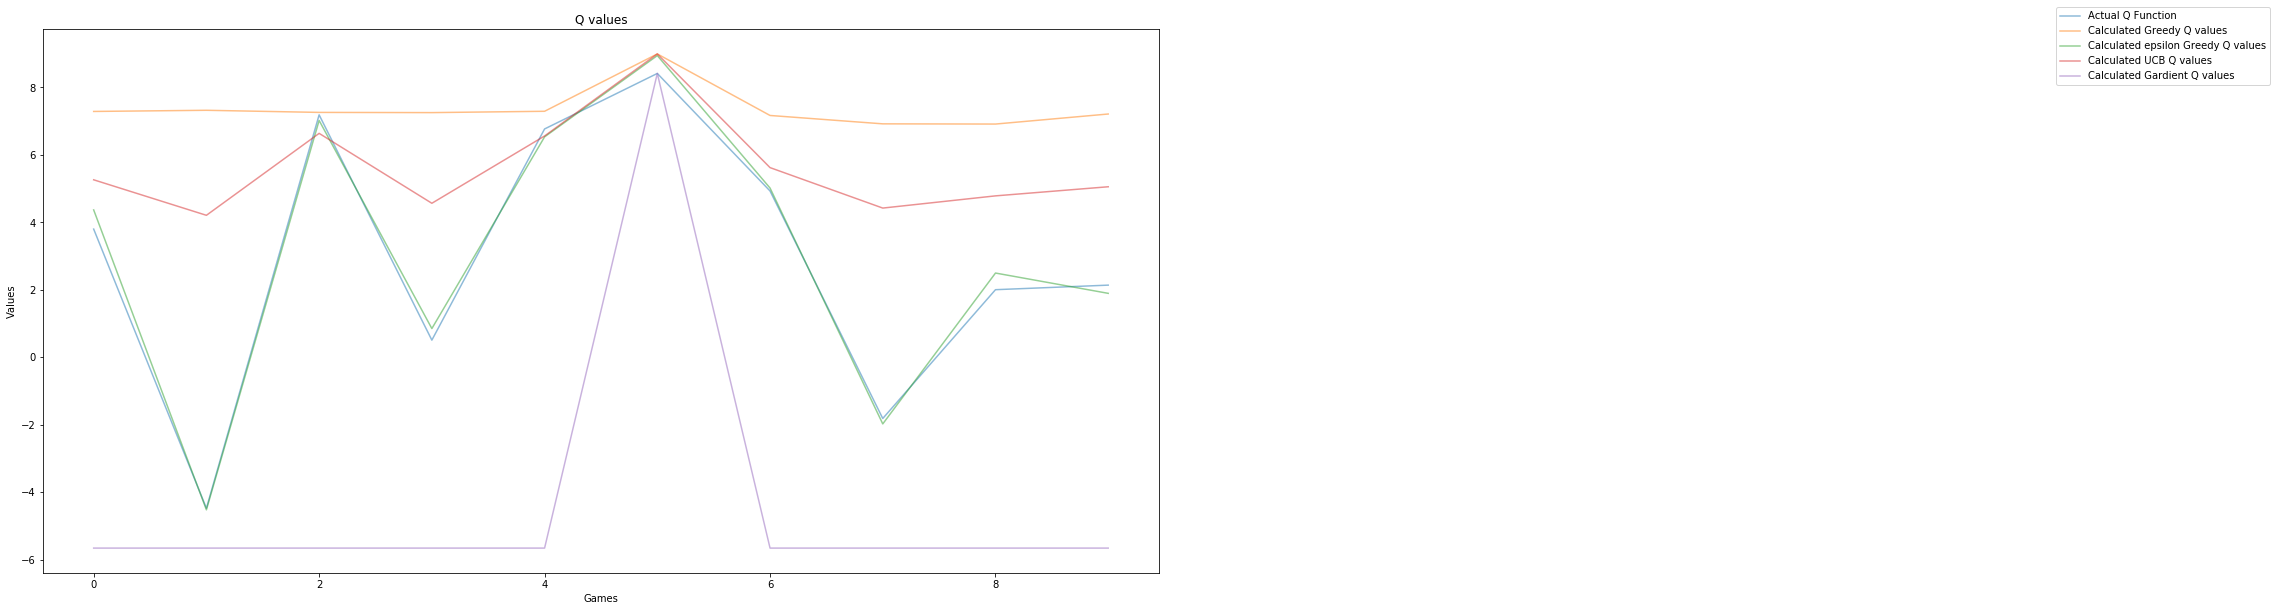

Difference of Actual and calculated values for Greedy values: 5.733799771636842 8415412.036495214
Difference of Actual and calculated values for epsilon Greedy values: 0.3380910710697994 7868915.809503566
Difference of Actual and calculated values for UCB values: 3.8780354546413407 8414895.429987796
Difference of Actual and calculated values for Gradient values: 8.335519248718587 8414227.504367031


/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


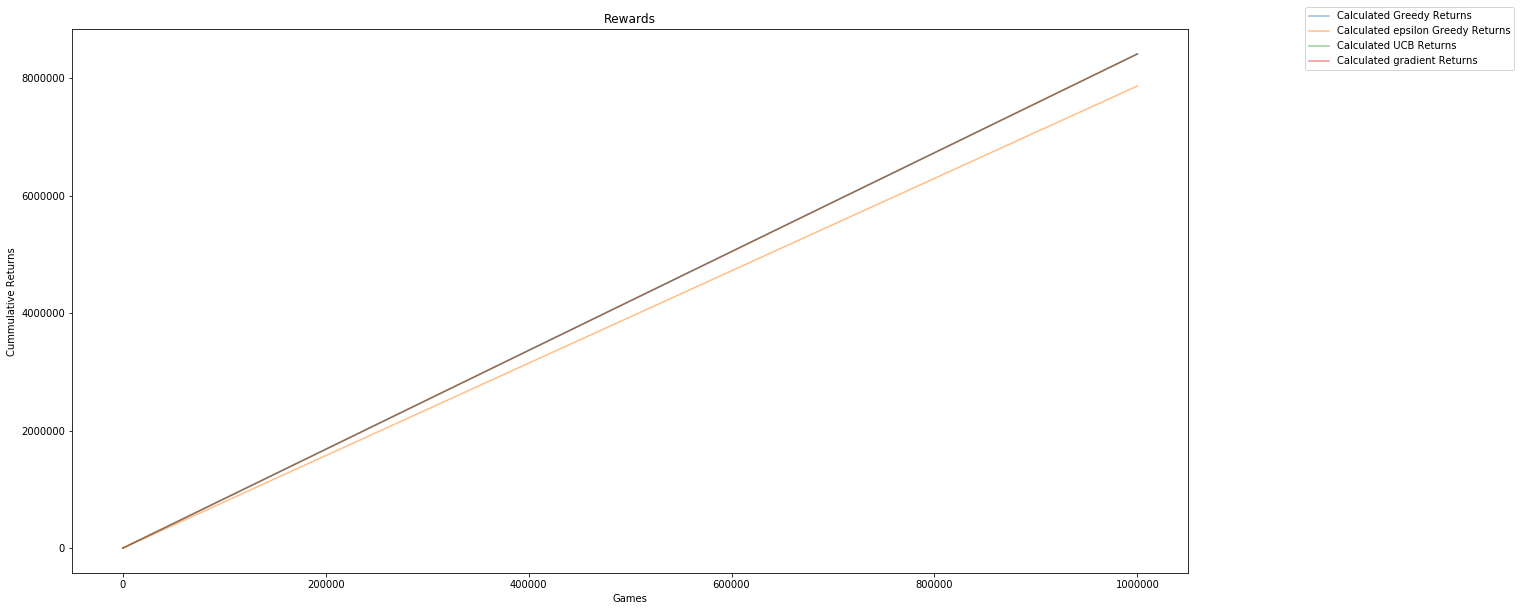

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


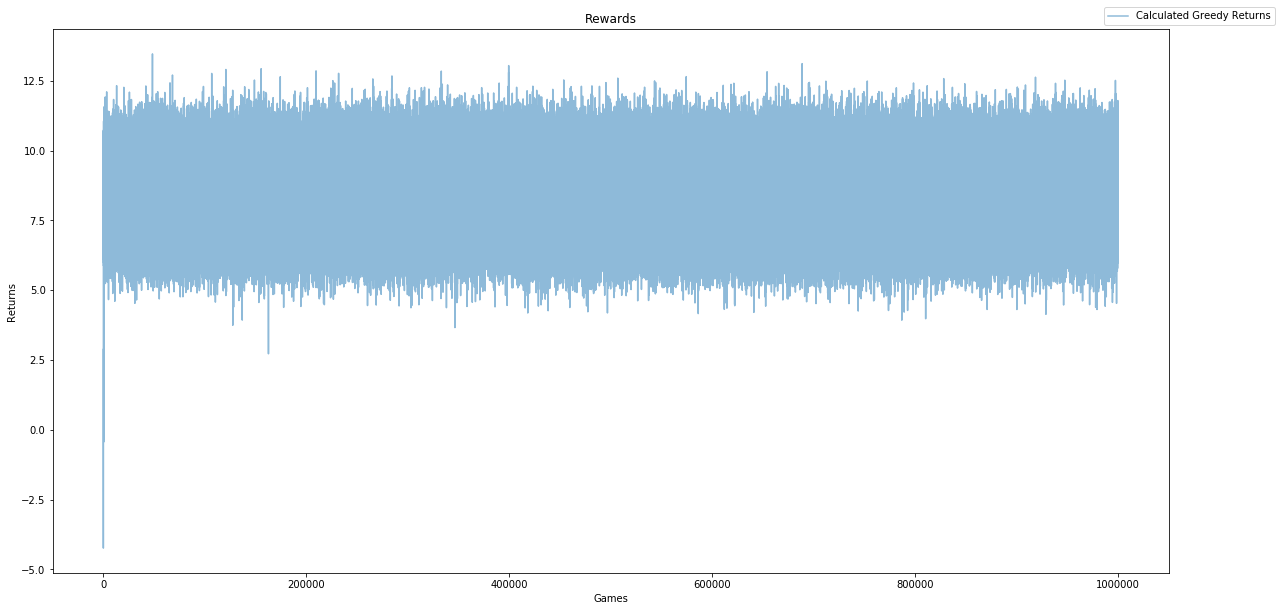

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


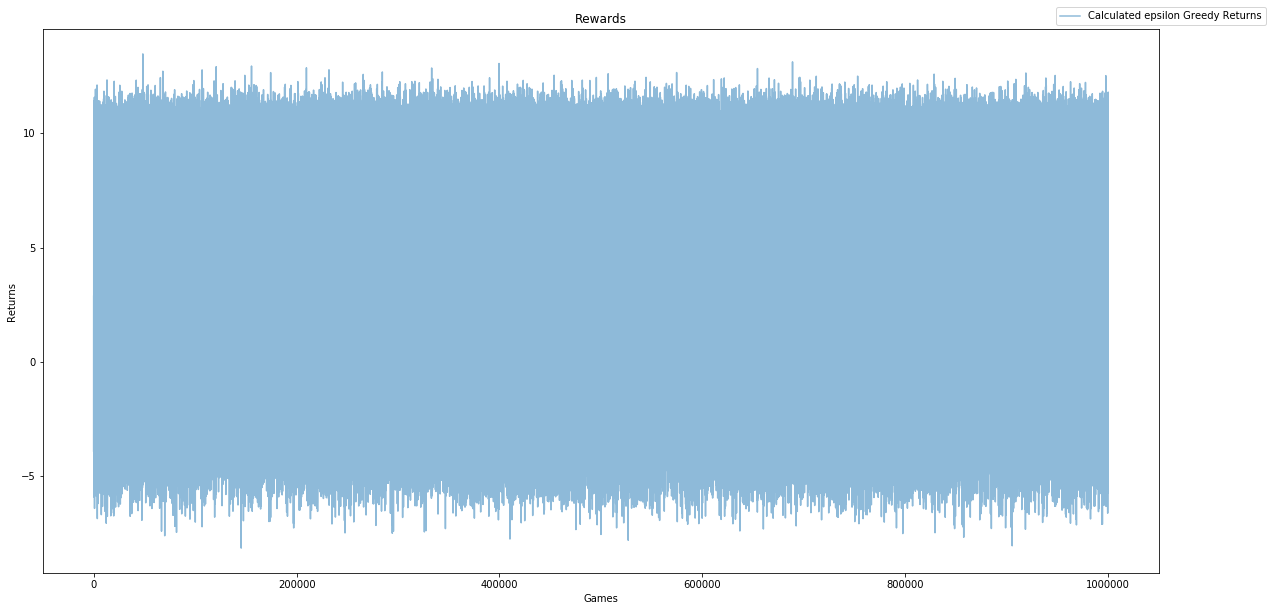

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


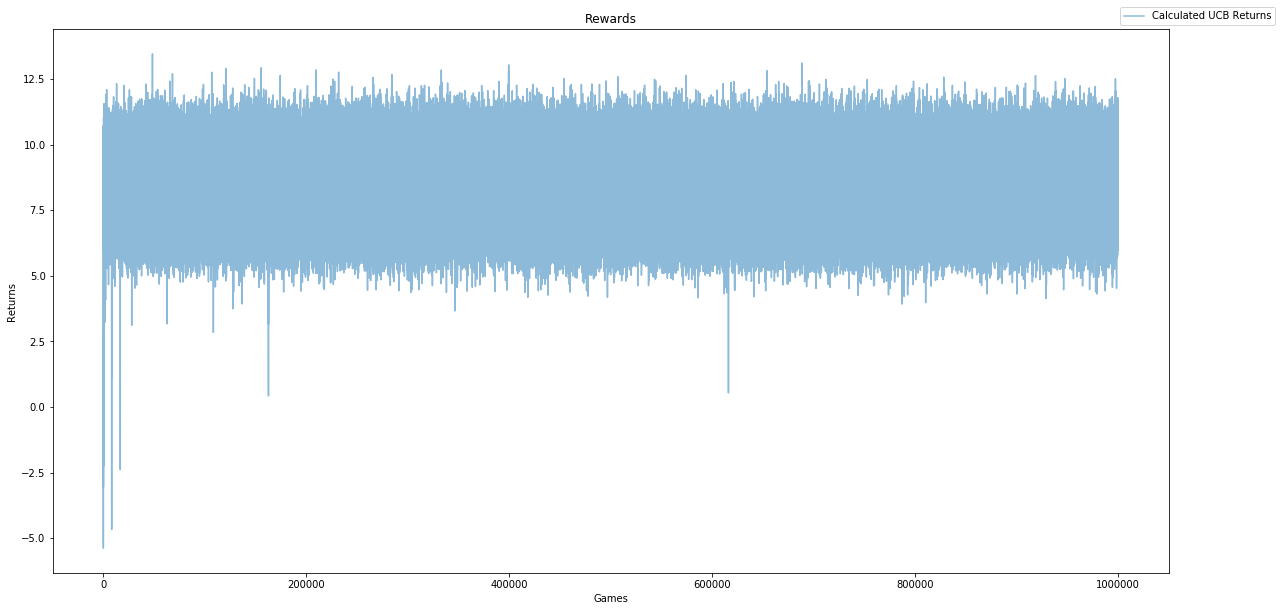

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


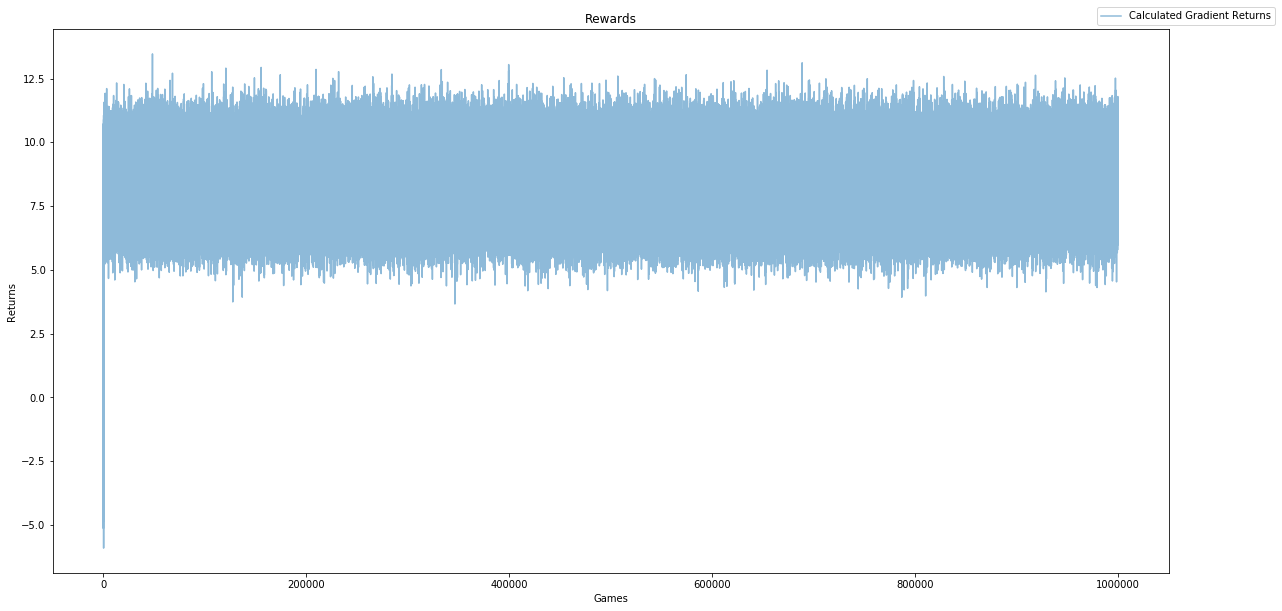

Best Action: 6


/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


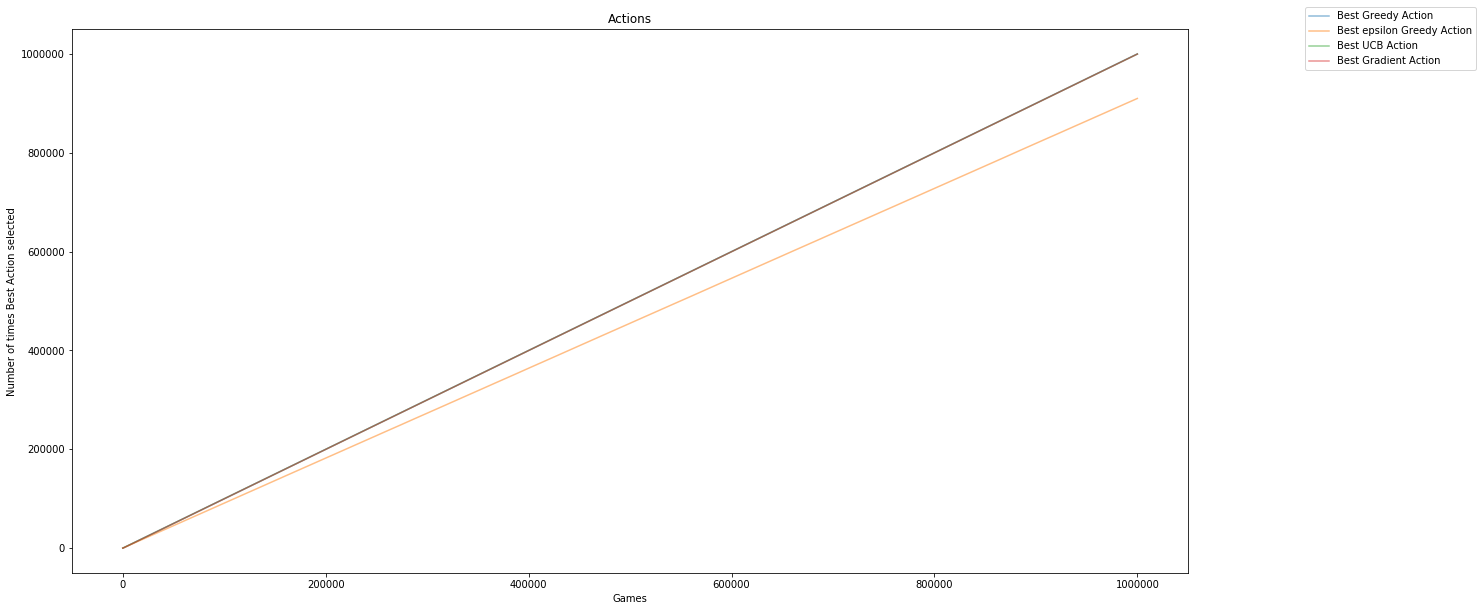

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


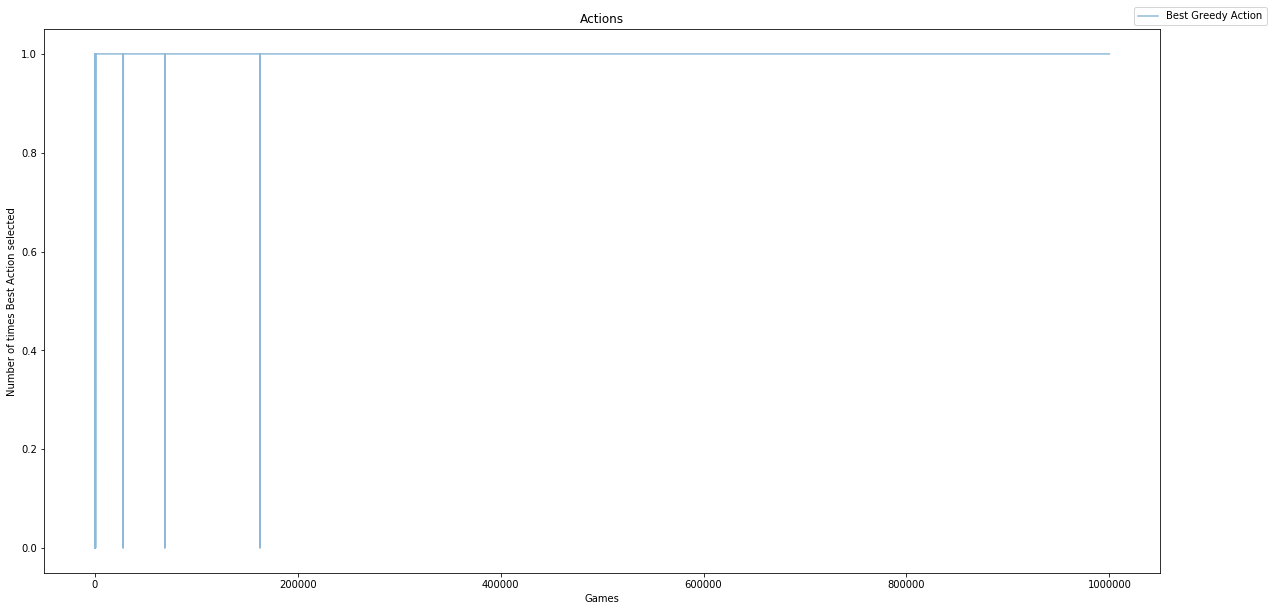

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


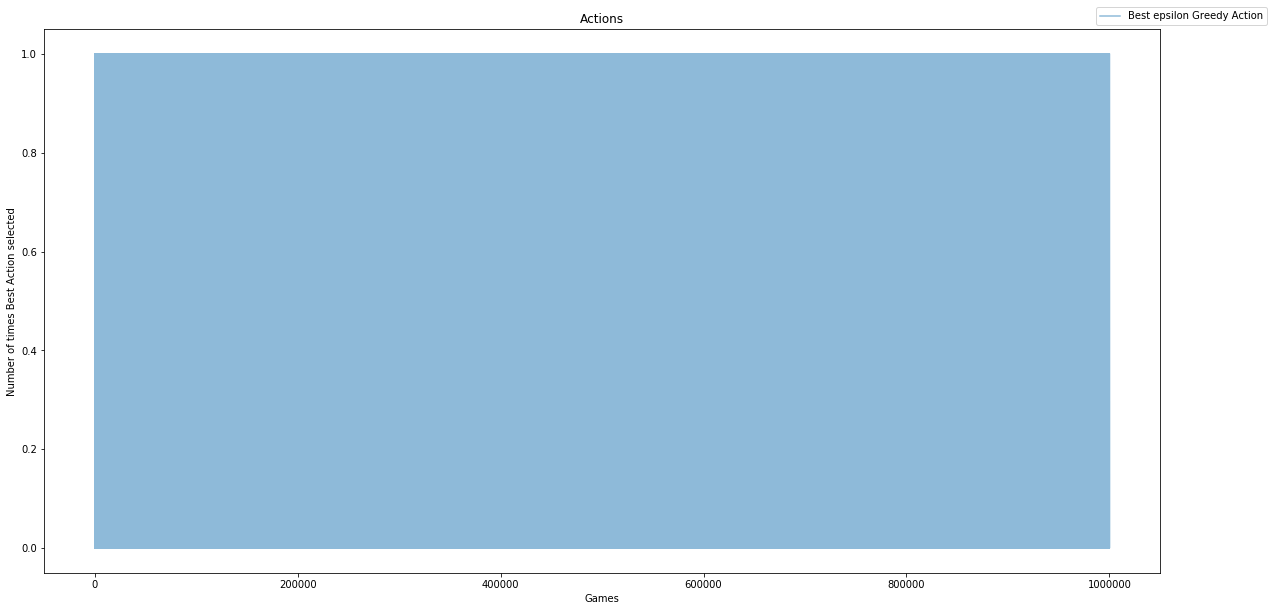

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


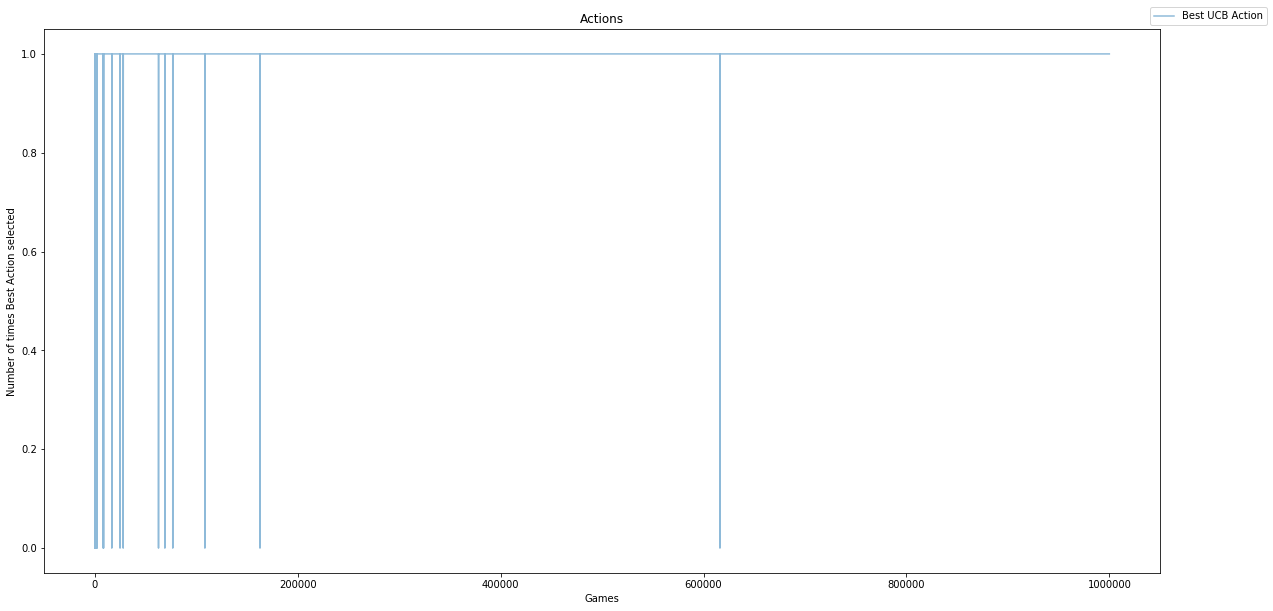

/home/sanket/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


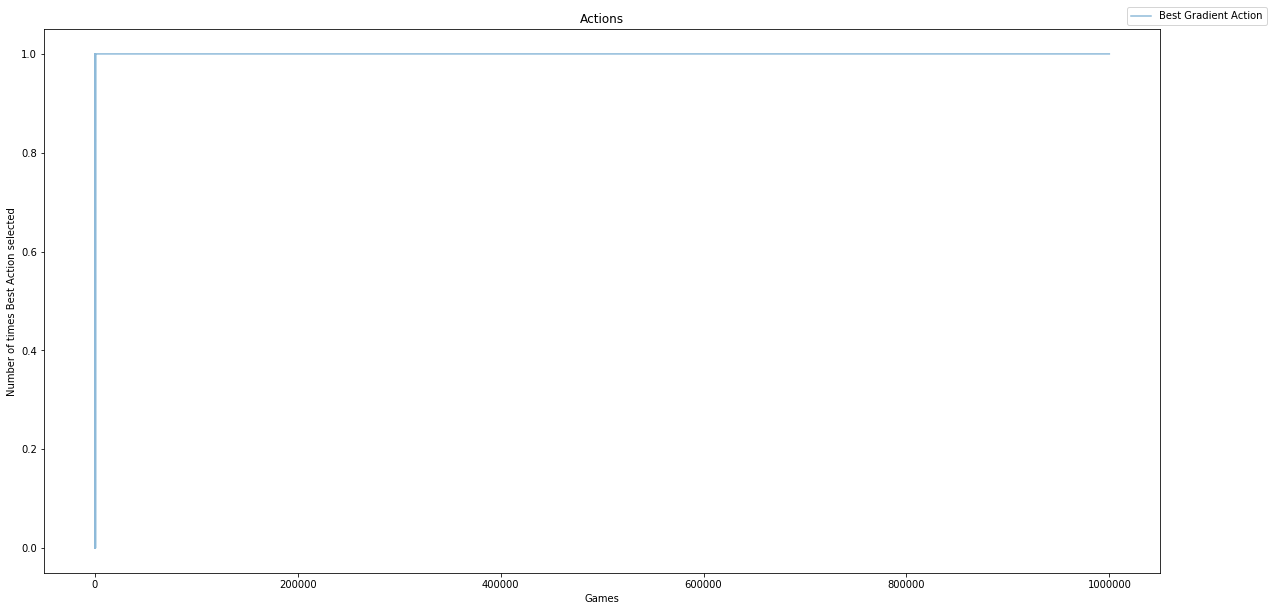

In [5]:
# With the Optimistic initial values
arms = 10
games = 1000000
bandits = KArmsBandit(arms, n_games=games, OIV=True)
bandits.play_game()
analyze(bandits, arms, games)